In [1]:
import numpy as np
import pandas as pd
import cv2

from sklearn.utils import shuffle
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('C:\\Users\\nithi\\OneDrive\\Desktop\\XAI\\archive (1)\\labels_train.csv')
df = shuffle(df)
df.head()

,frame,xmin,xmax,ymin,ymax,class_id
90331,1479502357734522474.jpg,93,100,141,149,1
126310,1479505668460069354.jpg,87,118,144,157,1
118573,1479505026914705007.jpg,176,189,141,154,1
83320,1479501650189539316.jpg,343,354,124,134,1
11340,1478021144222210109.jpg,232,255,126,148,2


In [3]:
classes = df.class_id.unique()
print(classes)

[1 2 5 3 4]


In [4]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as T

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transforms=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transforms = transforms
        self.classes = {1: 'car', 2: 'truck', 3: 'person', 4: 'bicycle', 5: 'traffic light'}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])  # 'frame' column
        img = Image.open(img_path).convert("RGB")
        
        # Load bounding boxes and labels
        boxes = torch.tensor([[self.df.iloc[idx, 1], self.df.iloc[idx, 3],  # xmin, ymin
                               self.df.iloc[idx, 2], self.df.iloc[idx, 4]]], dtype=torch.float32)  # xmax, ymax
        
        labels = torch.tensor([self.df.iloc[idx, 5]], dtype=torch.int64)  # class_id

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, target

# Dataset usage example
csv_file = 'C:\\Users\\nithi\\OneDrive\\Desktop\\XAI\\archive (1)\\labels_train.csv'
root_dir = 'C:\\Users\\nithi\\OneDrive\\Desktop\\XAI\\archive (1)\images\\'

# Add transformations (normalize, resize, etc.)
transform = T.Compose([T.ToTensor()])

dataset = CustomDataset(csv_file, root_dir, transforms=transform)


In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load pre-trained Faster R-CNN model with ResNet-50 backbone
def get_model(num_classes):
    # Load Faster R-CNN pre-trained on COCO dataset
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one for our dataset
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Create the model
num_classes = 6  # 5 classes + background
model = get_model(num_classes)


In [6]:
from torch.utils.data import DataLoader, Subset

# Use a smaller subset of the dataset for testing (e.g., first 100 samples)
subset_size = 100  # Adjust this for testing
subset_dataset = Subset(dataset, range(subset_size))

# Define the data loader with reduced num_workers
data_loader = DataLoader(subset_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))


In [7]:
import torch.optim as optim

# Move the model to the correct device (GPU if available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and learning rate setup
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 100    
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    print(f"Starting Epoch [{epoch+1}/{num_epochs}]")
    
    for step, (images, targets) in enumerate(data_loader):
        print("Loading batch...")
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        print("Starting forward pass...")
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        
        # Backward pass
        losses.backward()
        optimizer.step()

        # Print progress every 10 steps
        if step % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Step [{step}] - Loss: {losses.item():.4f}")
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {epoch_loss:.4f}")


Starting Epoch [1/10]
Loading batch...
Starting forward pass...
Epoch [1/10] - Step [0] - Loss: 2.1511
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Epoch [1/10] - Step [10] - Loss: 0.4079
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Loading batch...
Starting forward pass...
Epoch [1/10] - St

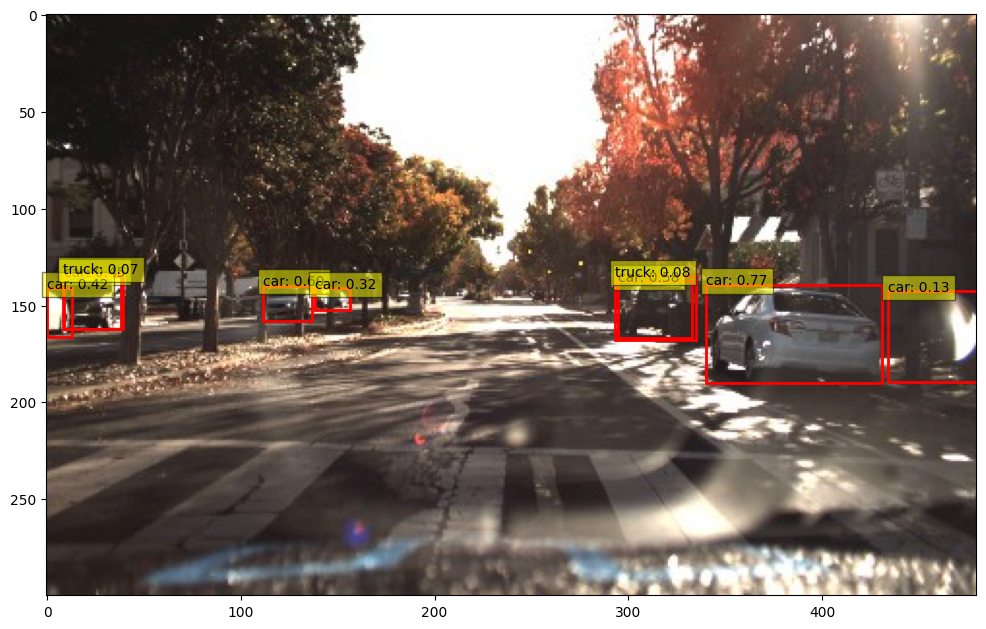

In [16]:
import matplotlib.pyplot as plt

# Visualization Function
def visualize_predictions(img, predictions):
    img = img.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)

    boxes = predictions[0]['boxes'].cpu().detach().numpy()
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()
    
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'{dataset.classes[label]}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()

# Example usage for testing visualization
test_image_path = 'C:\\Users\\nithi\\OneDrive\\Desktop\\XAI\\archive (1)\\images\\1478020232212661501.jpg'
test_img = Image.open(test_image_path).convert("RGB")
test_img_tensor = T.ToTensor()(test_img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    predictions = model(test_img_tensor)

visualize_predictions(test_img_tensor[0], predictions)


In [10]:
# Save the model
torch.save(model.state_dict(), "resnet50_faster_rcnn.pth")

# To load the model
model.load_state_dict(torch.load("resnet50_faster_rcnn.pth"))
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

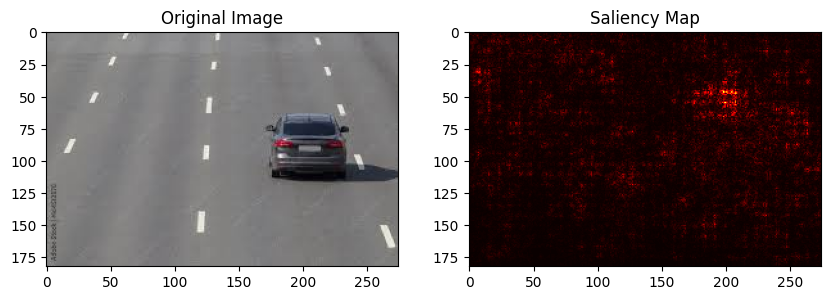

In [65]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

# Generate Saliency Map Function
def generate_saliency_map(model, img, target_index=None):
    model.eval()

    # Preprocess the image (convert to tensor and add batch dimension)
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Enable gradients for the input image tensor
    img_tensor.requires_grad = True
    
    # Forward pass
    outputs = model(img_tensor)
    
    # Select the class index (if not provided, pick the one with the highest score)
    if target_index is None:
        target_index = outputs.argmax().item()
    
    # Get the score for the target class
    target_score = outputs[0, target_index]
    
    # Zero all existing gradients
    model.zero_grad()
    
    # Backpropagate to compute gradients with respect to the input image
    target_score.backward()
    
    # Compute the saliency map by taking the absolute value of gradients
    saliency = img_tensor.grad.data.abs().squeeze().cpu().numpy()
    
    # Normalize the saliency map to range [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)
    
    # Plot the original image and the saliency map
    plt.figure(figsize=(10, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    
    # Saliency map (normalized)
    plt.subplot(1, 2, 2)
    plt.imshow(saliency[0], cmap='hot')  # Display the first channel
    plt.title("Saliency Map")
    
    plt.show()

# Example usage for saliency map
img_path = 'C:\\Users\\nithi\\OneDrive\\Desktop\\XAI\\plain car.jpeg'
img = Image.open(img_path).convert("RGB")

# Assuming your model is already loaded and 'device' is set to 'cpu' or 'cuda'
generate_saliency_map(model, img)



Model output structure: tensor([[-2.5805e-01,  1.5616e+00,  8.8742e-01,  1.9572e+00,  1.8428e+00,
          6.4179e-01,  1.4042e+00, -4.1874e-01, -8.4440e-01, -8.0520e-01,
         -1.9434e+00, -5.9706e-01,  2.6159e-01, -4.6877e-01, -1.4665e+00,
         -1.2313e+00, -1.3820e+00, -6.9448e-01,  4.1445e-01, -7.4410e-01,
         -1.8532e+00, -2.0221e+00, -2.5377e-01, -4.2601e-01, -2.1856e+00,
         -1.4776e+00, -1.2725e+00, -9.6755e-01, -6.1440e-01, -6.5373e-01,
         -1.2727e+00, -1.2444e+00, -1.1767e+00,  6.4721e-01,  1.5938e+00,
         -5.9072e-01,  1.8150e+00, -6.3650e-01, -1.3063e+00, -1.7020e+00,
         -1.3477e+00, -1.4879e+00, -2.1142e+00, -3.4199e+00, -1.6284e+00,
          9.1536e-01, -9.9936e-01, -3.1351e+00, -1.2400e+00,  1.8799e-01,
          1.8244e+00, -1.3309e+00, -1.6979e+00, -1.3914e+00, -1.9299e+00,
         -9.8493e-01, -1.4138e+00, -2.8846e+00,  9.4633e-01, -1.3127e+00,
          3.3866e-01, -2.2064e+00, -1.0373e+00, -2.0975e+00, -1.5190e+00,
          6.39

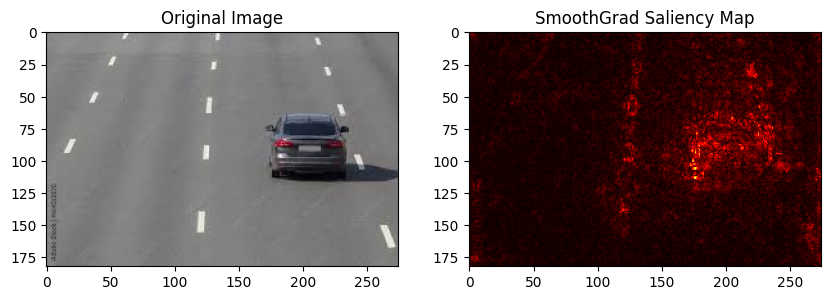

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def generate_smooth_grad(model, img, target_index=None, num_samples=50, noise_level=0.1):
    model.eval()
    
    # Preprocess the image
    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    img_tensor = img_tensor.to(device)
    
    # Ensure requires_grad is True for the image tensor
    img_tensor.requires_grad = True
    
    # Collect the gradients from noisy samples
    smooth_grad = torch.zeros_like(img_tensor)

    for i in range(num_samples):
        # Add noise to the image
        noise = torch.randn_like(img_tensor) * noise_level
        noisy_img = img_tensor + noise
        
        # Forward pass
        outputs = model(noisy_img)
        
        # Debug: Print the outputs to understand its structure
        print(f"Model output structure: {outputs}")
        
        # Ensure target_index is specified; for classification models,
        # outputs should be a tensor (batch_size, num_classes)
        if target_index is None:
            if isinstance(outputs, torch.Tensor):
                # If it's a tensor, use argmax to select the index of the highest-scoring class
                target_index = outputs.argmax().item()
            else:
                # If outputs are structured as a dictionary, as in Faster R-CNN
                scores = outputs[0]['scores']  # Extract the scores from the first image
                target_index = scores.argmax().item()

        # Get the loss (score) for the target object
        loss = outputs[0]['scores'][target_index] if isinstance(outputs[0], dict) else outputs[0, target_index]

        # Zero gradients before backpropagation
        model.zero_grad()

        # Backpropagate the loss to get the gradient
        loss.backward()

        # Accumulate gradients
        smooth_grad += img_tensor.grad.data

    # Average the gradients over all samples
    smooth_grad /= num_samples

    # Get the saliency map (maximum absolute gradient across color channels)
    saliency, _ = torch.max(smooth_grad.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    # Plot the original image and saliency map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='hot')
    plt.title("SmoothGrad Saliency Map")
    plt.show()

# Example usage with a sample image
img_path = 'C:\\Users\\nithi\\OneDrive\\Desktop\\XAI\\plain car.jpeg'
img = Image.open(img_path).convert("RGB")
generate_smooth_grad(model, img, num_samples=50, noise_level=0.1)


In [84]:
import torch
import numpy as np

def predict(images):
    model.eval()
    with torch.no_grad():
        # Move images to the appropriate device and get predictions
        images = torch.Tensor(images).permute(0, 3, 1, 2).to(device)  # Convert to (batch_size, channels, height, width)
        outputs = model(images)
        
        # For each output, we will create a score vector for the possible classes
        class_scores = []
        for output in outputs:
            # Get scores of detected objects
            scores = output['scores'].cpu().numpy()

            # Get labels of detected objects
            labels = output['labels'].cpu().numpy()

            # Create a vector with the length of the number of classes (e.g., 5 + 1 background)
            num_classes = 6  # Number of classes in your model (5 objects + 1 background)
            scores_vector = np.zeros(num_classes)

            # Assign the highest score for each label in the corresponding position
            for label, score in zip(labels, scores):
                scores_vector[label] = max(scores_vector[label], score)
            
            class_scores.append(scores_vector)

        return np.array(class_scores)  # Return a 2D array: (num_samples, num_classes)


In [ ]:
import lime
import lime.lime_image

# Load the image you want to explain
original_image = Image.open('C:\\Users\\nithi\\OneDrive\\Desktop\\XAI\\plain car.jpeg').convert('RGB')

# Create the LIME image explainer
explainer = lime.lime_image.LimeImageExplainer()

# Explain the instance (image) predictions
explanation = explainer.explain_instance(
    np.array(original_image),  # The image should be in numpy array format
    predict,  # The modified prediction function
    top_labels=5,  # Number of top labels to explain
    hide_color=0,  # Color to hide regions (0 = black)
    num_samples=1000  # Number of perturbed samples to generate
)

# Visualize the explanation
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Show explanation for the top predicted label
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=False)
img_boundry = mark_boundaries(temp / 255.0, mask)
plt.imshow(img_boundry)
plt.show()
